# Задание 1


### Целью этого задания является знакомство со стандартными контейнерами и некторыми функциями из стандартных библиотек для машинного обучения.

Напишите наивный байесовский классификатор и сравните его с реализацией NaiveBayesClassifier из библиотеки nltk.

Написанный вами классификатор должен обладать следубщими свойствами:
<ul>
<li>В предложенном интерфейсе класса должны быть реализованы все методы и все поля. Для их хранения предподсчитанных данных рекомендуется использовать контейнеры Counter или defaultdict из библиотеки collections. Для предсказания категории рекомендуется использовать numpy.</li>
<li>Должна использоваться модель, предложенная в теории.</li>
<li>Точность предсказаний не менее <b>0.9</b>!</li>
<li>После реализации класса протестируйте его с помощью кроссвалидации с k=10. Рекомендуется использовать класс KFold из библиотеки sklearn.</li>
<li>Постройте постройте диаграмму размаха для классификаторов (своего и из библиотеки).</li>
</ul>

### Теория

Теория находится в файле problems1-theory.pdf

# Решение

In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from nltk import NaiveBayesClassifier
from matplotlib import pyplot as plt

%pylab inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


### Прочитайте данные из файла

In [2]:
data_path = "ham-spam.csv"

In [3]:
sample = pd.read_csv(data_path)

In [4]:
X, y = np.array(sample["msg"]), np.array(sample["target"]) 

### Реализуйте все методы в классе NaiveBayes

In [5]:
class NaiveBayes(object):
    """
    Наивный байесовский классификатор.
    Для каждого входного сообщения слово учитывается один раз при расчете итоговой вероятности.

    Parameters
    ----------
    category_priors : default | None, optional, default None
        Априорные вероятности категорий.
        Если None, то классификатор должен сам их вычислить.

    weight : float, optional, default 1
        Вес одного слова в формуле взвешенной вероятности

    supposed_prob : float, optional, default 0.5
        Предполагаемая вероятность слова в категории
    """

    def __init__(self, category_priors=None, weight=1, supposed_prob=0.5):
        if category_priors is None:
            self.category_priors = defaultdict(int)
        else:
            self.category_priors = category_priors
        self.weight = weight
        self.supposed_prob = supposed_prob

        # Количество отдельных слов в заданной категории
        self.feature_category_counts = defaultdict(Counter)

        # Количество всех документов в данной категории
        self.category_doc_counts = Counter()

        # Количество встреч слова во всех сообщениях
        self.feature_counts = Counter()
    
    # Токенизируем, если нужно 
    def tokenize(self, text):
        if not isinstance(text, list):
            text = np.array(text.split(' '))
        return np.array(text)
        
    def fit(self, x_train, y_train):
        """
        Производит обучение наивного байесовского классификатора.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        y_train : list of str
            содержит список меток (названий категорий) для сообщений из x_train

        Returns
        -------
        self : object
            Returns self
        """
        
        # Список категорий
        self.cats = np.unique(y_train)
        
        # Подсчитываем количество категорий, документов и слов в каждой категории
        # и количество встреч слова во всех сообщениях
        
        for y in y_train:
            self.category_doc_counts[y] += 1
            
        for idx, x in enumerate(x_train):
            for word in np.unique(self.tokenize(x)):
                self.feature_counts[word] += 1
                self.feature_category_counts[y_train[idx]][word] += 1
                
        self.category_counts = Counter()
        for cat in self.cats:
            for elem in self.feature_category_counts[cat]:
                self.category_counts[cat] += self.feature_category_counts[cat][elem]

        # Если априорные вероятности категорий не заданы, то надо аппроксимировать их
        if len(self.category_priors) == 0:
            for cat in np.unique(y_train):
                self.category_priors[cat] = len(np.argwhere(y_train == cat)) / len(y_train)
                
        # Число всех слов
        sm = 0
        for elem in self.feature_counts:
            sm += self.feature_counts[elem]
        self.all_features = sm

        return self

    def predict(self, text):
        """
        Предсказывает метки категорий для text.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        Returns
        -------
        categories : list of str
            Возвращает названия категорий для text.
        """
        return self.cats[np.argmax(self.get_probs(text))]

    def score(self, text, labels):
        """
        Возвращает точность предсказаний на text для правильных категорий labels.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.
        labels : list of str
            Список категорий для каждого токена из text.

        Returns
        -------
        acc : float
            Точность предсказания.
        """
        
        res = 0
        for idx, x in enumerate(text):
            res += self.predict(x) == labels[idx]
            
        acc = res / len(labels)
            
        return acc

    def get_probs(self, text):
        """
        Считает вероятности принадлежности текста (text) к каждой из категорий

        Parameters
        ----------
        text : list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.

        Returns
        -------
        probs : list of float
            Возвращает вероятности probs всех категорий для текста text
            в порядке их следования в self.category_doc_counts.
        """
        
        probs = [self.get_category_prob(cat, text) for cat in self.cats]

        return probs

    def get_category_prob(self, cat, text):
        """
        Считает логарифм вероятность принадлежности сообщения text к категории cat.

        Parameters
        ----------
        cat : str
            Название категории.

        text : list of str
            Список из слов.

        Returns
        -------
        log_prob : float
            Возвращает логарифм вероятности категории cat для текста text.
        """
        text = self.tokenize(text)
        
        log_prob = np.log(self.category_priors[cat])
        for word in text:
                pr = self.get_weighted_feature_prob(cat, word)
                if pr == 0:
                    pr = self.supposed_prob
                log_prob += np.log(pr)

        return log_prob

    def get_weighted_feature_prob(self, cat, feature):
        """
        Вычисляет взвешенную вероятность P(Слово|Категория).

        Parameters
        ----------
        cat : str
            Название категории.

        feature : str
            Слово из текста.

        Returns
        -------
        prob : float
            Возвращает взвешенную вероятность слова feature при условии категории cat.
        """
        
        prob = (self.feature_category_counts[cat][feature] /self.category_counts[cat]
                + self.weight * self.feature_counts[feature] / self.all_features) / (self.weight + 1)

        return prob

    def get_categories(self):
        """
        Возвращает список названий всех категорий.
        Returns
        -------
        cat : list of str
        """
        return self.cats
pass


### Сравните вашу реализацию и реализацию из библиотеки nltk

Для использования классификатора из библиотеки не забудьте предподготовить данные. Для подсчета точности этого классификатора можете использовать accuracy_score из метрик sklearn. Для подсчета точности предсказаний вашего классификатора используйте функцию score, которую вы опишете.

In [6]:
import tqdm

all_words = {}

def prepare_train_for_nltk(X, y):
    train = np.column_stack((X, y))
    t = []
    all_words = set(word.lower() for passage in train for word in passage[0].split(" "))
    for x in tqdm.tqdm(train):
        t.append(({word: (word in x[0].split(" ")) for word in all_words}, x[1]))
    #t = [({word: (word in x[0].split(" ")) for word in all_words}, x[1]) for x in train]
    return t, all_words

In [7]:
res = prepare_train_for_nltk(X, y)
transformed_data, all_words = res[0], res[1]

100%|██████████| 2893/2893 [1:32:59<00:00,  1.93s/it]


In [11]:
np_data = np.array(transformed_data)

In [32]:
# Используйте процедуру KFold для проверки качества классификаторов
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
kf = KFold(n_splits=10, random_state=47)

scores_nltk, scores_mine = [], []

for train_index, test_index in tqdm.tqdm(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    nb_mine = NaiveBayes(weight=0.1, supposed_prob=0.6)
    nb_nltk = NaiveBayesClassifier.train(np_data[train_index])
    nb_mine.fit(X_train, y_train)
    scores_mine.append(nb_mine.score(X_test, y_test))
    scores_nltk.append(accuracy_score([nb_nltk.classify(featureset=t) for t in np_data[test_index, 0]], y_test))

10it [39:16, 235.68s/it]


### Постройте графики размаха для двух классификаторов на одной фигуре.

Рекомендуется использовать встроенные функции построения графиков в pandas.

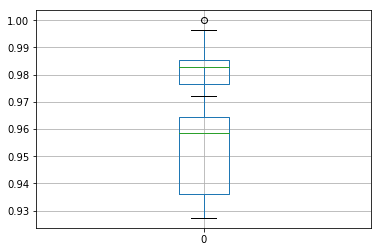

In [34]:
df_nltk = pd.DataFrame(scores_nltk)
df_mine = pd.DataFrame(scores_mine)
ax = df_nltk.boxplot()
df_mine.boxplot()

** Вывод: ** Как видно из диаграммы разбросов выше, наш классификатор более точен и обучается заметно быстрее (2 секунды против 4 минут)